<a href="https://colab.research.google.com/github/winterForestStump/bank_marketing/blob/main/ml_bank_marketing_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will build a simple binary classification model based on the Bank Marketing dataset. Our goal is to design and deploy a web application that can classify whether a customer will sign up for a term deposit or not.

## Importing Libraries

In [1]:
%%capture
!pip install skops
!pip install gradio

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
import time
import skops.io as sio
import gradio as gr

We will use following stack:
* Scikit-learn: ML library for experiments with models
* Skops: Share the scikit-learn based models and put it in production.
* Gradio: ML web applications framework.
* HuggingFace Spaces: free machine learning model and application hosting platform.

## Downloading dataset

We will use a smaller dataset

In [3]:
bm_df = pd.read_csv("https://raw.githubusercontent.com/winterForestStump/bank_marketing/main/data_/bank.csv",header=0, delimiter=';')
bm_df = bm_df.sample(frac = 1)
bm_df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4281,52,management,married,secondary,no,335,no,no,cellular,21,oct,411,1,182,1,failure,yes
1360,31,technician,single,secondary,no,1014,yes,no,cellular,23,jul,158,4,-1,0,unknown,no
879,28,technician,single,tertiary,no,183,yes,yes,unknown,28,may,62,2,-1,0,unknown,no


## Initial Data Analysis

There are 4521 clients rows, and 16 features (including a class column `y`), no missing values:

In [4]:
bm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 4281 to 4323
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 635.8+ KB


Feature statistics:

In [5]:
bm_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [6]:
bm_df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


To get more familiar with data let's look at some outliers:

In [7]:
bm_df[bm_df['age']==max(bm_df['age'])]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3311,87,retired,married,primary,no,230,no,no,cellular,30,oct,144,1,-1,0,unknown,yes


In [8]:
bm_df[bm_df['age']==min(bm_df['age'])]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2780,19,student,single,secondary,no,302,no,no,cellular,16,jul,205,1,-1,0,unknown,yes
503,19,student,single,primary,no,103,no,no,cellular,10,jul,104,2,-1,0,unknown,yes
1900,19,student,single,unknown,no,0,no,no,cellular,11,feb,123,3,-1,0,unknown,no
3233,19,student,single,unknown,no,1169,no,no,cellular,6,feb,463,18,-1,0,unknown,no


In [9]:
bm_df[bm_df['balance']==max(bm_df['balance'])]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3700,60,retired,married,primary,no,71188,no,no,cellular,6,oct,205,1,-1,0,unknown,no


In [10]:
bm_df[bm_df['balance']==min(bm_df['balance'])]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no


We can also take a look at the distribution of the numerical input variables by creating a histogram for each.

We can see that all of the variables do not have a Gaussian-like distribution. Depending on the choice of algorithm, the data may benefit from standardization.

<ipython-input-11-63eb2c02322d>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  bm_df.hist(ax=ax)


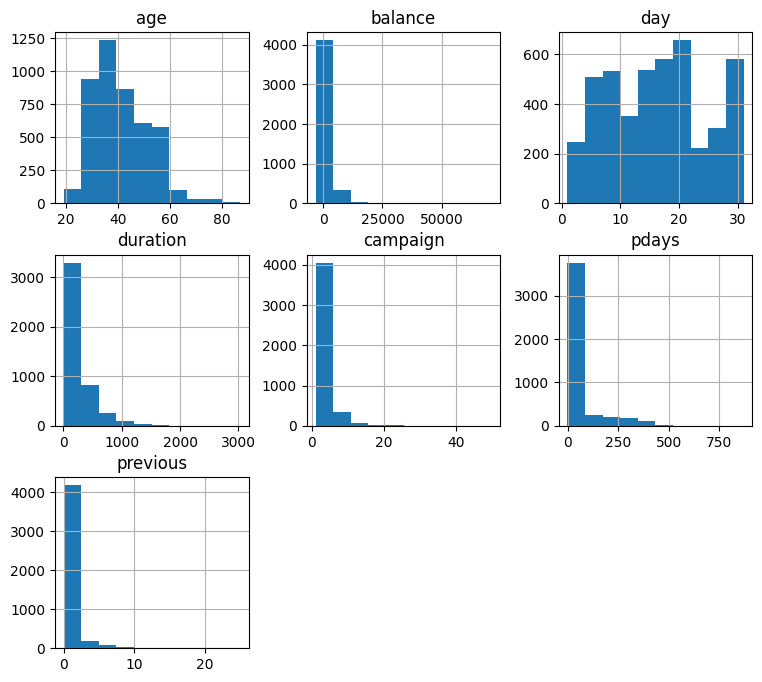

In [11]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(9, 8))
bm_df.hist(ax=ax)
pyplot.show()

Now we need to find a class distribution:

In [12]:
print(bm_df['y'].value_counts())
print(f'\n{bm_df["y"].value_counts(normalize=True)}')

no     4000
yes     521
Name: y, dtype: int64

no     0.88476
yes    0.11524
Name: y, dtype: float64


The dataset is unbalanced.

## Features and target sets preparation

We will not use features with previous contact information, this is due to the complexity of their interpretation and usage in practice

Remove target column 'y' from the dataset and create 'target' variable:

In [13]:
bm_df = bm_df.drop(columns=['day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'])

target = bm_df.loc[:, ["y"]]
target = target["y"].replace({'yes': 1, 'no': 0})

data = bm_df.drop("y", axis=1)

## Setup ML Experiment

Set the number of trials, repeats and splits for cross-validation. Settings CV parameters to 5 is not a good choice: I did that only for the purpose of fitting the reasonable timing. In a real experiment, rather use 10.

In [14]:
NUM_TRIALS = 5
NUM_INNER_REPEATS = 5
NUM_INNER_SPLITS = 5
NUM_OUTER_SPLITS = 5

Pipeline creation function:

In [15]:
def get_pipe(estimator):
    return Pipeline([
        ('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(), [0,5]),
                                                        ('cat', OneHotEncoder(handle_unknown='ignore'),[1,2,3,4,6,7,8])])),
        ('estimator', estimator)])

Cross-validation function. F1 score (balanced F-score or F-measure) has been choosen as a score for refitting:

In [16]:
def nested_cv(estimator, grid, features, targets):
    start = time.time()
    f1 = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    baccs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    accs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))

    for i in range(NUM_TRIALS):
        print("Running Outer CV in iteration: ", i, " at ", time.time()-start)
        pipe = get_pipe(estimator)
        inner_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=i)
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)

        clf = GridSearchCV(estimator=pipe, param_grid=grid, cv=inner_cv, scoring=('f1'), refit='f1')
        cv_result = cross_validate(clf, X=data, y=target, cv=outer_cv, scoring=('f1', 'balanced_accuracy', 'accuracy'))

        f1[i] = cv_result['test_f1']
        baccs[i] = cv_result['test_balanced_accuracy']
        accs[i] = cv_result['test_accuracy']
        fit_times[i] = cv_result['fit_time']
        test_times[i] = cv_result['score_time']

    print('Total time: ', (time.time()-start), 'sec.')
    return f1, baccs, accs, fit_times, test_times

Add the results scores into the table:

In [17]:
def add_result(results, name, f1, baccs, accs, fit_times, test_times):
    row = {
        'name': name,
        'f1_mean': f1.mean(),
        'f1_std': f1.std(),
        'f1_min': f1.min(),
        'f1_max': f1.max(),
        'bacc_mean': baccs.mean(),
        'bacc_std': baccs.std(),
        'bacc_min': baccs.min(),
        'bacc_max': baccs.max(),
        'acc_mean': accs.mean(),
        'fit_time': fit_times.mean(),
        'test_time': test_times.mean()
    }
    return pd.concat([results, pd.DataFrame([row])], ignore_index=True)

Classificators parameters grid:

In [18]:
baseline_grid = {'estimator__strategy': ['prior']}
forest_grid = {'estimator__criterion': ['log_loss'], 'estimator__n_estimators': [10,50,100,200]}
poly_grid = {'estimator__C': [0.1,1,10], 'estimator__degree': [2,3,4]}
adaboost_grid = {'estimator__n_estimators': [10,50,90]}

In [19]:
results = pd.DataFrame()

## Baseline classifier

For the baseline we will use simple Dummz Classifier, basically accuracy of the baseline should result in the share of the biggest class

In [20]:
baseline = DummyClassifier(random_state=1)
f1, baccs, accs, fit_times, test_times = nested_cv(baseline, baseline_grid, data, target)
results = add_result(results, 'baseline', f1, baccs, accs, fit_times, test_times)

Running Outer CV in iteration:  0  at  1.4066696166992188e-05
Running Outer CV in iteration:  1  at  3.2621288299560547
Running Outer CV in iteration:  2  at  9.129032373428345
Running Outer CV in iteration:  3  at  13.307679653167725
Running Outer CV in iteration:  4  at  19.323286771774292
Total time:  22.07484483718872 sec.


## Training ML algorithms

Random Forests:

In [21]:
random_forest = RandomForestClassifier(random_state=1)
f1, baccs, accs, fit_times, test_times = nested_cv(random_forest, forest_grid, data, target)
results = add_result(results, 'random_forest', f1, baccs, accs, fit_times, test_times)

Running Outer CV in iteration:  0  at  1.6927719116210938e-05
Running Outer CV in iteration:  1  at  165.4079451560974
Running Outer CV in iteration:  2  at  329.930871963501
Running Outer CV in iteration:  3  at  503.12604236602783
Running Outer CV in iteration:  4  at  671.5772798061371
Total time:  839.3005635738373 sec.


SVM:

In [22]:
poly_svm = SVC(kernel = 'poly', random_state=1, class_weight='balanced')
f1, baccs, accs, fit_times, test_times = nested_cv(poly_svm, poly_grid, data, target)
results = add_result(results, 'svm (poly)', f1, baccs, accs, fit_times, test_times)

Running Outer CV in iteration:  0  at  1.9550323486328125e-05
Running Outer CV in iteration:  1  at  450.83756971359253
Running Outer CV in iteration:  2  at  906.9495165348053
Running Outer CV in iteration:  3  at  1369.3769426345825
Running Outer CV in iteration:  4  at  1839.6766910552979
Total time:  2309.261972427368 sec.


AdaBoost:

In [23]:
adaboost = AdaBoostClassifier(random_state=1)
f1, baccs, accs, fit_times, test_times = nested_cv(adaboost, adaboost_grid, data, target)
results = add_result(results, 'adaboost', f1, baccs, accs, fit_times, test_times)

Running Outer CV in iteration:  0  at  1.9311904907226562e-05
Running Outer CV in iteration:  1  at  67.86583232879639
Running Outer CV in iteration:  2  at  137.90320992469788
Running Outer CV in iteration:  3  at  205.9282102584839
Running Outer CV in iteration:  4  at  273.7196238040924
Total time:  345.287743806839 sec.


## Evaluating the models

All the results, sorted by F1 score

In [24]:
results.sort_values(by='f1_mean', ascending=False)

,name,f1_mean,f1_std,f1_min,f1_max,bacc_mean,bacc_std,bacc_min,bacc_max,acc_mean,fit_time,test_time
2,svm (poly),0.277955,0.020023,0.230947,0.307116,0.630098,0.028261,0.566010,0.673601,0.600708,92.278543,0.090300
1,random_forest,0.114466,0.030005,0.057554,0.166667,0.522165,0.011035,0.499856,0.540268,0.866092,33.544314,0.025764
3,adaboost,0.045623,0.017294,0.000000,0.089286,0.509155,0.004850,0.498125,0.522163,0.882061,13.787388,0.022362
0,baseline,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.500000,0.884760,0.867826,0.012900


The best model is SVM(poly)

Check the best parameters of the model:

In [25]:
def train_prod_model(estimator, grid):
    pipe = get_pipe(estimator)
    cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=1)
    clf = GridSearchCV(estimator=pipe, param_grid=grid, scoring=('f1'), refit="f1",cv=cv)
    clf.fit(data, target)
    return clf

In [26]:
clf = train_prod_model(poly_svm, poly_grid)
print(clf.best_params_)

{'estimator__C': 0.1, 'estimator__degree': 4}


## Creating a production Pipeline

Pipeline with column transformation: for numerical - scaling, for categorical - one-hot encoding

In [33]:
pipe = Pipeline(steps=[
        ('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(), [0,5]),
                                                        ('cat', OneHotEncoder(handle_unknown='ignore'),[1,2,3,4,6,7,8])])),
        ("model", SVC(kernel = 'poly', random_state=1, C=0.1, degree=4, class_weight='balanced')),
    ])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.3, shuffle=True, random_state=1)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1206
           1       0.18      0.68      0.29       151

    accuracy                           0.63      1357
   macro avg       0.56      0.65      0.52      1357
weighted avg       0.85      0.63      0.70      1357



In [35]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  [0, 5]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1, 2, 3, 4, 6, 7, 8])])),
                ('model',
                 SVC(C=0.1, class_weight='balanced', degree=4, kernel='poly',
                     random_state=1))])

## Saving the Model

Skops is a library to deploy scikit-learn model into products. We will use it to save the model.This library allows you to initialize and create a model repository compatible with Hugging Face Hub

In [36]:
sio.dump(pipe, "bank_marketing_pipe.skops")

## Next steps

* Building Web Application

Using Gradio build a simple classification user interface.

* Deploying the Machine Learning Model

Creating the space on the Hugging Face and add our model and the app file.

